In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import rc

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
device

device(type='mps', index=0)

## Resnet50 (epochs=30)

In [54]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision.models as models
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수
from efficientnet_pytorch import EfficientNet

# 이미지 전처리 및 데이터 분할
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
dataset_path = "/Users/taeyoung/Desktop/딥러닝/project"

# def target_transforms(target):
#     return torch.FloatTensor([target])


# ImageFolder를 사용하여 전체 데이터셋을 불러옵니다.
train_dataset = ImageFolder(dataset_path + '/train', transform=train_transforms)
val_dataset = ImageFolder(dataset_path + '/val', transform=valid_transforms)
test_dataset = ImageFolder(dataset_path + '/test', transform=test_transforms)


# DataLoader 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# ResNet-50 모델 불러오기
model = models.resnet50(pretrained=True).to(device)
num_features = model.fc.in_features

# Fully connected 레이어 수정
model.fc = nn.Sequential(
    nn.Linear(num_features, 2)  # 클래스 개수에 맞게 (이진 분류이므로 2)
).to(device)


model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD로 변경

# 리스트 초기화
res50_train_acc_lst = []
res50_train_loss_lst = []
res50_val_acc_lst = []
res50_val_loss_lst = []

state={}

# 모델 훈련
epochs = 30
for epoch in range(1, epochs+1):
    
    train_loss = 0
    total = 0
    correct = 0
    train_acc = 0
    
    model.train()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # 정확도 계산
        _, predicted = torch.max(outputs, 1)  
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = round(train_loss / len(train_loader), 3)
    train_acc = round((correct / total) * 100, 2)  
    
    print(f'Trainset {epoch}/{epochs} Loss : {train_loss}, Accuracy : {train_acc}%')
    res50_train_acc_lst.append(train_acc)
    res50_train_loss_lst.append(train_loss)
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 검증 데이터셋에 대한 손실과 정확도 계산
    val_loss = 0
    val_total = 0
    val_correct = 0
    val_acc = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    
        val_loss = round(val_loss / len(val_loader), 3)  # 검증 데이터셋의 손실 평균 계산
        val_acc = round((val_correct / val_total) * 100, 2)  # 검증 데이터셋의 정확도 계산
    
        print(f'Validation {epoch}/{epochs} Loss : {val_loss}, Accuracy : {val_acc}%')
        print()

        res50_val_acc_lst.append(val_acc)
        res50_val_loss_lst.append(val_loss)
        
        if np.max(res50_val_acc_lst) <= val_acc:
            state['epoch'] = epoch
            state['net'] = model.state_dict()

            state['train_loss'] = train_loss
            state['val_loss'] = val_loss

            state['train_acc'] = train_acc
            state['val_acc'] = val_acc

# 모델 저장
torch.save(state, '/Users/taeyoung/Desktop/딥러닝/resnet50_{}_{}.pth'.format(str(state['epoch']), str(state['val_acc'])))

/Users/taeyoung/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/taeyoung/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainset 1/30 Loss : 0.632, Accuracy : 62.94%
Validation 1/30 Loss : 0.566, Accuracy : 68.75%

Trainset 2/30 Loss : 0.464, Accuracy : 78.14%
Validation 2/30 Loss : 0.5, Accuracy : 78.12%

Trainset 3/30 Loss : 0.345, Accuracy : 85.32%
Validation 3/30 Loss : 0.507, Accuracy : 77.84%

Trainset 4/30 Loss : 0.263, Accuracy : 88.68%
Validation 4/30 Loss : 0.452, Accuracy : 82.1%

Trainset 5/30 Loss : 0.224, Accuracy : 90.23%
Validation 5/30 Loss : 0.435, Accuracy : 82.67%

Trainset 6/30 Loss : 0.171, Accuracy : 93.14%
Validation 6/30 Loss : 0.429, Accuracy : 84.09%

Trainset 7/30 Loss : 0.159, Accuracy : 93.66%
Validation 7/30 Loss : 0.413, Accuracy : 86.65%

Trainset 8/30 Loss : 0.112, Accuracy : 96.57%
Validation 8/30 Loss : 0.418, Accuracy : 86.93%

Trainset 9/30 Loss : 0.082, Accuracy : 96.96%
Validation 9/30 Loss : 0.46, Accuracy : 87.78%

Trainset 10/30 Loss : 0.077, Accuracy : 97.35%
Validation 10/30 Loss : 0.444, Accuracy : 84.09%

Trainset 11/30 Loss : 0.056, Accuracy : 98.06%
Valid

### Acc and Loss 시각화

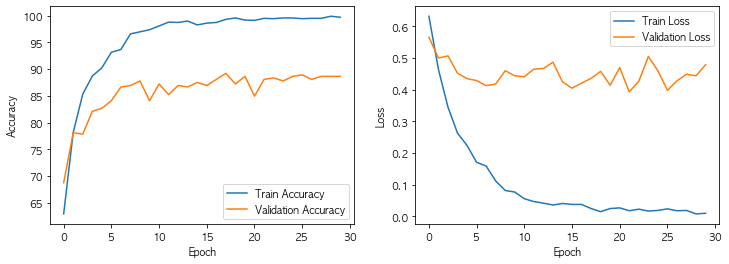

In [55]:
# 정확도 및 손실을 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(res50_train_acc_lst, label='Train Accuracy')
plt.plot(res50_val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(res50_train_loss_lst, label='Train Loss')
plt.plot(res50_val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Resnet18 (epochs=30)

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision.models as models
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수
from efficientnet_pytorch import EfficientNet

# 이미지 전처리 및 데이터 분할
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
dataset_path = "/Users/taeyoung/Desktop/딥러닝/project"

# def target_transforms(target):
#     return torch.FloatTensor([target])


# ImageFolder를 사용하여 전체 데이터셋을 불러옵니다.
train_dataset = ImageFolder(dataset_path + '/train', transform=train_transforms)
val_dataset = ImageFolder(dataset_path + '/val', transform=valid_transforms)
test_dataset = ImageFolder(dataset_path + '/test', transform=test_transforms)


# DataLoader 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# ResNet-18 모델 불러오기
model = models.resnet18(pretrained=True).to(device)
num_features = model.fc.in_features

# Fully connected 레이어 수정
model.fc = nn.Sequential(
    nn.Linear(num_features, 2)  # 클래스 개수에 맞게 (이진 분류이므로 2)
).to(device)


model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD로 변경

# 리스트 초기화
train_acc_lst = []
train_loss_lst = []
val_acc_lst = []
val_loss_lst = []

state={}

# 모델 훈련
epochs = 30
for epoch in range(1, epochs+1):
    
    train_loss = 0
    total = 0
    correct = 0
    train_acc = 0
    
    model.train()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # 정확도 계산
        _, predicted = torch.max(outputs, 1)  
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = round(train_loss / len(train_loader), 3)
    train_acc = round((correct / total) * 100, 2)  
    
    print(f'Trainset {epoch}/{epochs} Loss : {train_loss}, Accuracy : {train_acc}%')
    train_acc_lst.append(train_acc)
    train_loss_lst.append(train_loss)
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 검증 데이터셋에 대한 손실과 정확도 계산
    val_loss = 0
    val_total = 0
    val_correct = 0
    val_acc = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    
        val_loss = round(val_loss / len(val_loader), 3)  # 검증 데이터셋의 손실 평균 계산
        val_acc = round((val_correct / val_total) * 100, 2)  # 검증 데이터셋의 정확도 계산
    
        print(f'Validation {epoch}/{epochs} Loss : {val_loss}, Accuracy : {val_acc}%')
        print()

        val_acc_lst.append(val_acc)
        val_loss_lst.append(val_loss)
        
        if np.max(val_acc_lst) <= val_acc:
            state['epoch'] = epoch
            state['net'] = model.state_dict()

            state['train_loss'] = train_loss
            state['val_loss'] = val_loss

            state['train_acc'] = train_acc
            state['val_acc'] = val_acc

# 모델 저장
torch.save(state, '/Users/taeyoung/Desktop/딥러닝/resnet18_{}_{}.pth'.format(str(state['epoch']), str(state['val_acc'])))

/Users/taeyoung/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainset 1/30 Loss : 0.619, Accuracy : 66.49%
Validation 1/30 Loss : 0.505, Accuracy : 74.72%

Trainset 2/30 Loss : 0.375, Accuracy : 82.66%
Validation 2/30 Loss : 0.468, Accuracy : 79.55%

Trainset 3/30 Loss : 0.259, Accuracy : 88.55%
Validation 3/30 Loss : 0.403, Accuracy : 82.95%

Trainset 4/30 Loss : 0.173, Accuracy : 93.4%
Validation 4/30 Loss : 0.398, Accuracy : 84.38%

Trainset 5/30 Loss : 0.154, Accuracy : 93.86%
Validation 5/30 Loss : 0.401, Accuracy : 83.24%

Trainset 6/30 Loss : 0.091, Accuracy : 96.83%
Validation 6/30 Loss : 0.406, Accuracy : 83.81%

Trainset 7/30 Loss : 0.053, Accuracy : 98.32%
Validation 7/30 Loss : 0.349, Accuracy : 86.08%

Trainset 8/30 Loss : 0.05, Accuracy : 98.51%
Validation 8/30 Loss : 0.341, Accuracy : 87.5%

Trainset 9/30 Loss : 0.037, Accuracy : 98.9%
Validation 9/30 Loss : 0.359, Accuracy : 87.5%

Trainset 10/30 Loss : 0.033, Accuracy : 99.16%
Validation 10/30 Loss : 0.365, Accuracy : 88.07%

Trainset 11/30 Loss : 0.025, Accuracy : 99.29%
Valida

### Acc and Loss 시각화

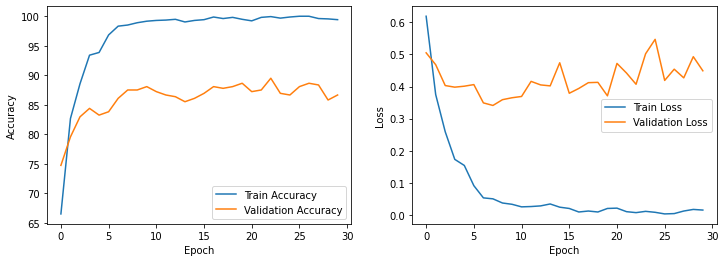

In [12]:
# 정확도 및 손실을 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_lst, label='Train Accuracy')
plt.plot(val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_lst, label='Train Loss')
plt.plot(val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Efficient b0 (epochs=30)

In [14]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision.models as models
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수
from efficientnet_pytorch import EfficientNet


# 이미지 전처리 및 데이터 분할
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
dataset_path = "/Users/taeyoung/Desktop/딥러닝/project"

# def target_transforms(target):
#     return torch.FloatTensor([target, 1 - target])

# def target_transforms(target):
#     return torch.FloatTensor([target])


# ImageFolder를 사용하여 전체 데이터셋을 불러옵니다.
train_dataset = ImageFolder(dataset_path + '/train', transform=train_transforms)
val_dataset = ImageFolder(dataset_path + '/val', transform=valid_transforms)
test_dataset = ImageFolder(dataset_path + '/test', transform=test_transforms)

# DataLoader 설정
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# ResNet-50 모델 불러오기 (사전학습된 가중치 사용)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

# # fc 제외하고 freeze
# for n, p in model.named_parameters():
#     if '_fc' not in n:
#         p.requires_grad = False
# model = torch.nn.parallel.DistributedDataParallel(model)

# num_features = model.fc.in_features

# # Fully connected 레이어 수정
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 128),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(128,1),
#     nn.Sigmoid()  # 시그모이드 활성화 함수를 사용하여 확률값 출력
# ).to(device)


model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD로 변경

# 리스트 초기화
eff_train_acc_lst = []
eff_train_loss_lst = []
eff_val_acc_lst = []
eff_val_loss_lst = []

state={}

# 모델 훈련
epochs = 30
for epoch in range(1, epochs+1):
    
    train_loss = 0
    total = 0
    correct = 0
    train_acc = 0
    
    model.train()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # 정확도 계산
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = round(train_loss / len(train_loader), 3)  # 미니배치 수로 나누어 평균을 계산
    train_acc = round((correct / total) * 100, 2)  # 백분율로 변환
    
    print(f'Trainset {epoch}/{epochs} Loss : {train_loss}, Accuracy : {train_acc}%')
    eff_train_acc_lst.append(train_acc)
    eff_train_loss_lst.append(train_loss)
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 검증 데이터셋에 대한 손실과 정확도 계산
    val_loss = 0
    val_total = 0
    val_correct = 0
    val_acc = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            val_loss += criterion(outputs, labels).item()
            
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    
        val_loss = round(val_loss / len(val_loader), 3)  # 검증 데이터셋의 손실 평균 계산
        val_acc = round((val_correct / val_total) * 100, 2)  # 검증 데이터셋의 정확도 계산
    
        print(f'Validation {epoch}/{epochs} Loss : {val_loss}, Accuracy : {val_acc}%')
        print()

        eff_val_acc_lst.append(val_acc)
        eff_val_loss_lst.append(val_loss)
        
        if np.max(eff_val_acc_lst) <= val_acc:
            state['epoch'] = epoch
            state['net'] = model.state_dict()

            state['train_loss'] = train_loss
            state['val_loss'] = val_loss

            state['train_acc'] = train_acc
            state['val_acc'] = val_acc

# 모델 저장
torch.save(state, '/Users/taeyoung/Desktop/딥러닝/efficientb0_{}_{}.pth'.format(str(state['epoch']), str(state['val_acc'])))

Loaded pretrained weights for efficientnet-b0
Trainset 1/30 Loss : 0.659, Accuracy : 62.68%
Validation 1/30 Loss : 0.656, Accuracy : 61.65%

Trainset 2/30 Loss : 0.568, Accuracy : 77.36%
Validation 2/30 Loss : 0.619, Accuracy : 64.77%

Trainset 3/30 Loss : 0.507, Accuracy : 79.04%
Validation 3/30 Loss : 0.577, Accuracy : 69.32%

Trainset 4/30 Loss : 0.462, Accuracy : 81.69%
Validation 4/30 Loss : 0.536, Accuracy : 74.43%

Trainset 5/30 Loss : 0.423, Accuracy : 83.25%
Validation 5/30 Loss : 0.499, Accuracy : 76.42%

Trainset 6/30 Loss : 0.394, Accuracy : 84.15%
Validation 6/30 Loss : 0.479, Accuracy : 75.57%

Trainset 7/30 Loss : 0.374, Accuracy : 85.64%
Validation 7/30 Loss : 0.448, Accuracy : 78.12%

Trainset 8/30 Loss : 0.338, Accuracy : 86.87%
Validation 8/30 Loss : 0.431, Accuracy : 79.26%

Trainset 9/30 Loss : 0.319, Accuracy : 87.26%
Validation 9/30 Loss : 0.419, Accuracy : 77.56%

Trainset 10/30 Loss : 0.294, Accuracy : 87.19%
Validation 10/30 Loss : 0.402, Accuracy : 80.68%

Tr

### acc and loss 시각화

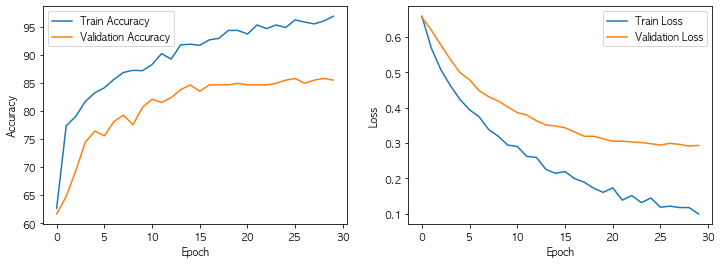

In [17]:
# 정확도 및 손실을 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(eff_train_acc_lst, label='Train Accuracy')
plt.plot(eff_val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eff_train_loss_lst, label='Train Loss')
plt.plot(eff_val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()